In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import sparse
from scipy.sparse.linalg import svds
from scipy import linalg

import pyemb as eb

In [58]:
np.random.seed(42)

### Load dataset

In [59]:
window = 15*60

day_1_start = (8*60+30)*60
day_1_end = (17*60+30)*60
day_2_start = ((24+8)*60+30)*60
day_2_end = ((24+17)*60+30)*60

T1 = int((day_1_end - day_1_start) // window)
T2 = int((day_2_end - day_2_start) // window)
T = T1 + T2

print(f'Number of time windows: {T}')

fname = 'data/ia-primary-school-proximity-attr.edges'
file = open(fname)

nodes = []
node_labels = []
edge_tuples = []

for line in file:
    node_i, node_j, time, id_i, id_j = line.strip('\n').split(',')
    
    if day_1_start <= int(time) < day_1_end:
        t = (int(time) - day_1_start) // window
    elif day_2_start <= int(time) < day_2_end:
        t = T1 + (int(time) - day_2_start) // window
    else:
        continue
    
    if node_i not in nodes:
        nodes.append(node_i)
        if id_i != "Teachers":
            id_i = "Class " + id_i
        node_labels.append(id_i)
    
    if node_j not in nodes:
        nodes.append(node_j)
        if id_j != "Teachers":
            id_j = "Class " + id_j
        node_labels.append(id_j)
    
    edge_tuples.append([t, node_i, node_j])
    
edge_tuples = np.unique(edge_tuples, axis=0)
nodes = np.array(nodes)

n = len(nodes)
print(f'Number of nodes: {n}')

node_dict = dict(zip(nodes[np.argsort(node_labels)], range(n)))
node_labels = np.sort(node_labels)

As = []
for t in range(T):
    idx = np.where(edge_tuples[:, 0] == str(t))[0]
    A = sparse.coo_matrix((np.ones(len(idx)), ([node_dict[edge_tuples[i, 1]] for i in idx], [node_dict[edge_tuples[i, 2]] for i in idx])), shape=(n,n))
    As.append((A + A.T).sign())

Number of time windows: 72
Number of nodes: 242


### Embed the dynamic network

In [61]:
from pyemb.embedding import dyn_embed

# Embed the graph using unfolded regularURLSEd Laplacian spectral embedding
d = 10
URLSE_emb = dyn_embed(As, d=d, method="URLSE")

### Quick visualisations

In [62]:
# Quick animation of the embedding
from pyemb.tools import plot_dyn_embedding

plot_dyn_embedding(URLSE_emb, n, T, node_labels)

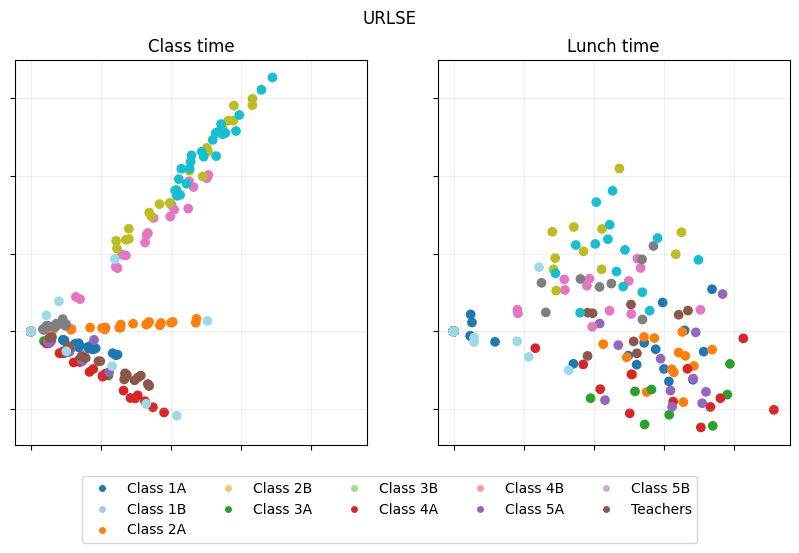

In [64]:
# Or plot the embedding at specific times
from pyemb.tools import plot_embedding_snapshots

def school_legend(fig):
    # Add a legend 
    handles = []
    for i, label in enumerate(np.unique(node_labels)):
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab20(i), label=label))

    fig.legend(handles=handles, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.1))


points_of_interest = [5, 14]
point_labels = ["Class time", "Lunch time"]
fig = plot_embedding_snapshots(URLSE_emb, n, node_labels, points_of_interest, point_labels)

school_legend(fig)
_ = fig.suptitle("URLSE")

### Degree-correct the embedding

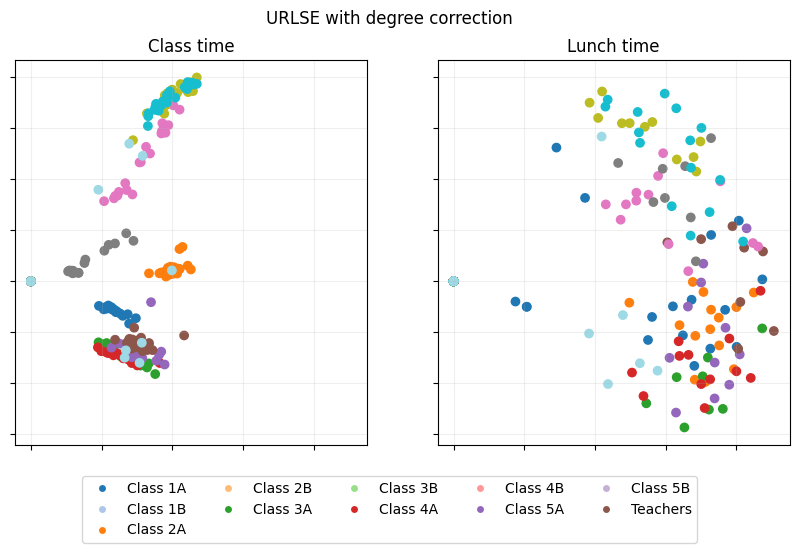

In [65]:
URLSE_emb_dc = eb.tools.degree_correction(URLSE_emb)
URLSE_fig = plot_embedding_snapshots(URLSE_emb_dc, n, node_labels, points_of_interest, point_labels)
_ = URLSE_fig.suptitle("URLSE with degree correction")
school_legend(URLSE_fig)

## Compare embedding methods

#### URLSE

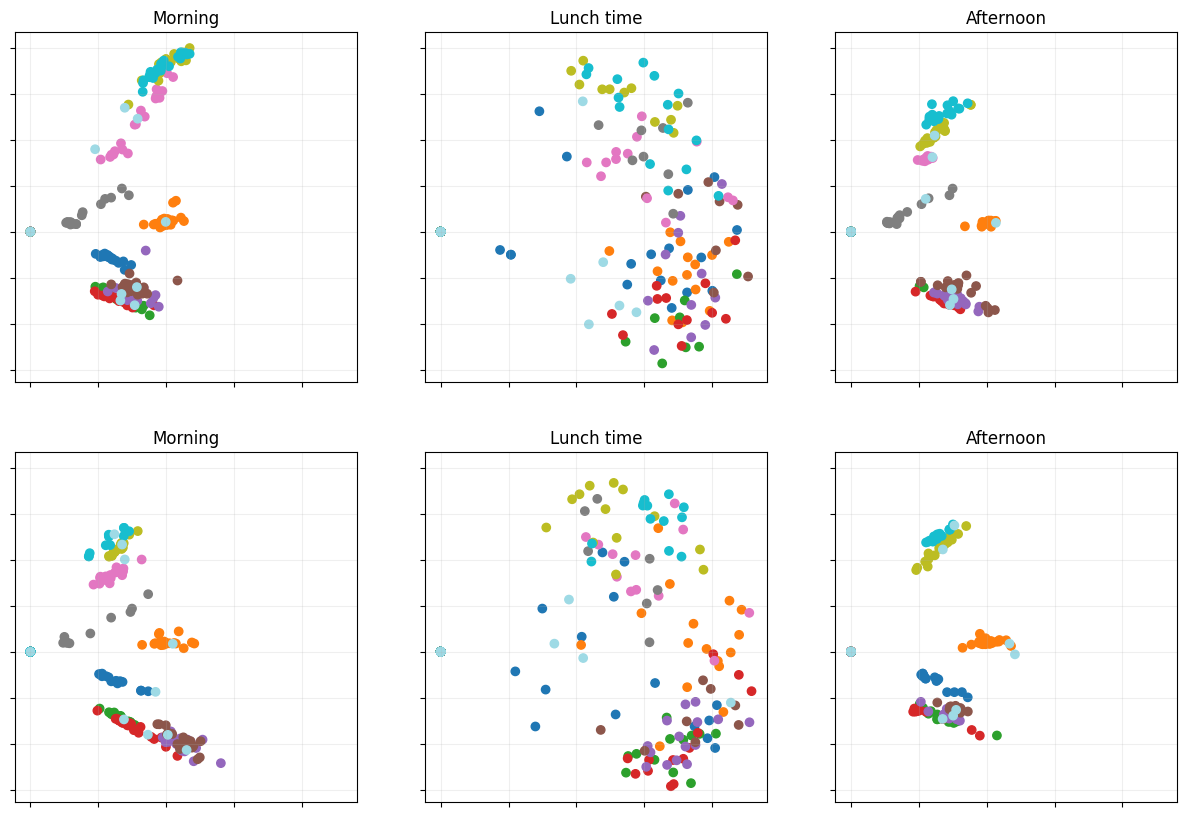

In [66]:
URLSE_emb = dyn_embed(As, d, method="URLSE")
URLSE_emb = eb.tools.degree_correction(URLSE_emb)

points_of_interest = [5, 14, 27, 41, 50, 63]
point_labels = ["Morning", "Lunch time", "Afternoon"] * 2
URLSE_fig = plot_embedding_snapshots(URLSE_emb, n, node_labels, points_of_interest, point_labels, max_cols=3)

#### Independent spectral embedding

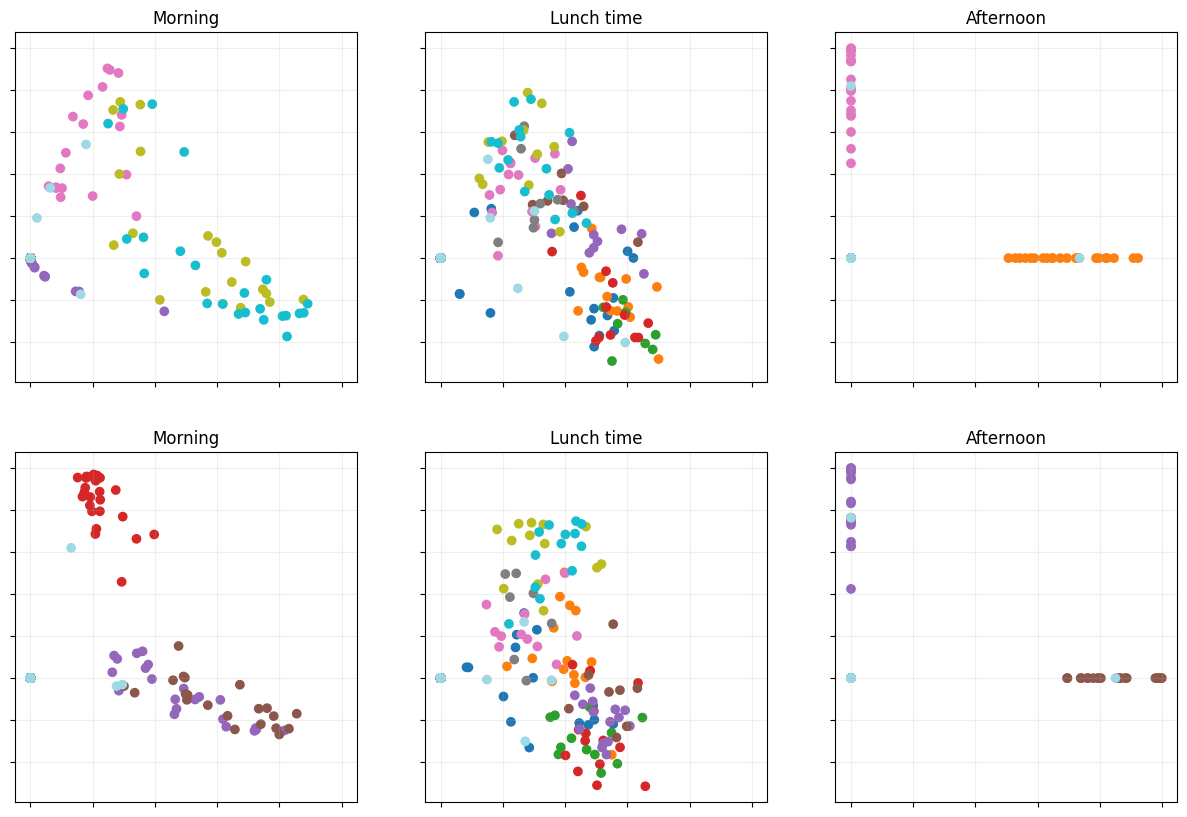

In [67]:
ISE_emb = dyn_embed(As, d, method="ISE")
ISE_emb = eb.tools.degree_correction(ISE_emb)

points_of_interest = [5, 14, 27, 41, 50, 63]
point_labels = ["Morning", "Lunch time", "Afternoon"] * 2
ISE_fig = plot_embedding_snapshots(ISE_emb, n, node_labels, points_of_interest, point_labels, max_cols=3)

### Omnibus embedding

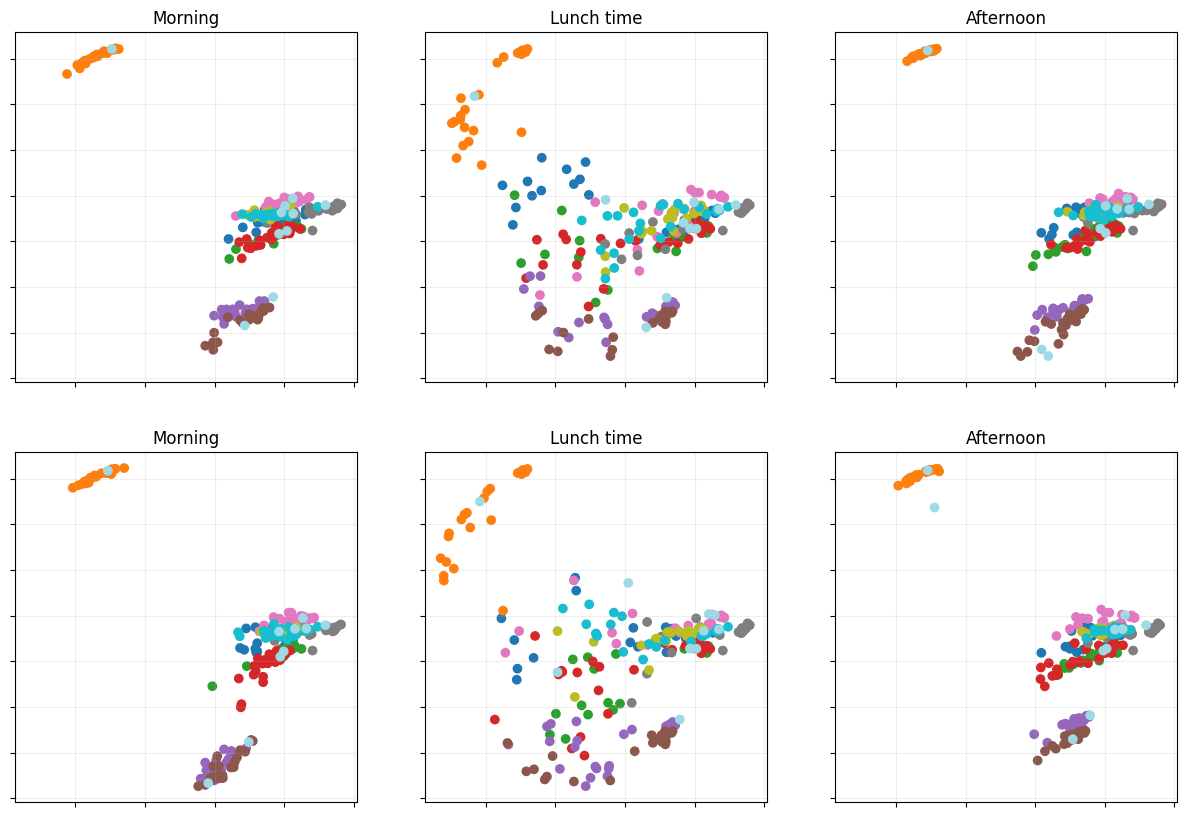

In [68]:
OMNI_emb = dyn_embed(As, d, method="OMNI")
OMNI_emb = eb.tools.degree_correction(OMNI_emb)

points_of_interest = [5, 14, 27, 41, 50, 63]
point_labels = ["Morning", "Lunch time", "Afternoon"] * 2
OMNI_fig = plot_embedding_snapshots(OMNI_emb, n, node_labels, points_of_interest, point_labels, max_cols=3)